In [16]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [17]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [18]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [19]:
np.random.seed(0)

Generate datasets. We choose the size big enough to see the scalability of the algorithms, but not too big to avoid too long running times

In [33]:
def make_variable_std_blobs(n_samples, centers, stds):
    blobs = []
    labels = []
    n_samples_per = n_samples / len(centers)
    for n, center, std in zip(range(len(centers)), centers, stds):
        blob = [[np.random.normal(c, s) for c, s in zip(center, std)] for _ in range(n_samples_per)]
        label = [n] * n_samples_per
        blobs += blob
        labels += label 
    return [np.array(blobs), np.array(labels)]  

In [34]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
my_blobs = make_variable_std_blobs(1500, [(10, 4), (-10, -5), (-10, 20)], [(1,5), (4, 4), (10, 10)])
clusters_list = [noisy_circles, noisy_moons, blobs, no_structure, my_blobs]
clusters_list = [noisy_circles, noisy_moons, blobs, my_blobs]


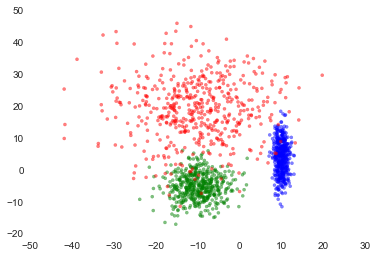

In [35]:
X = my_blobs[0]
y_pred = my_blobs[1]
plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10, alpha=0.5)

In [15]:
def clustering_list(X):
    pass

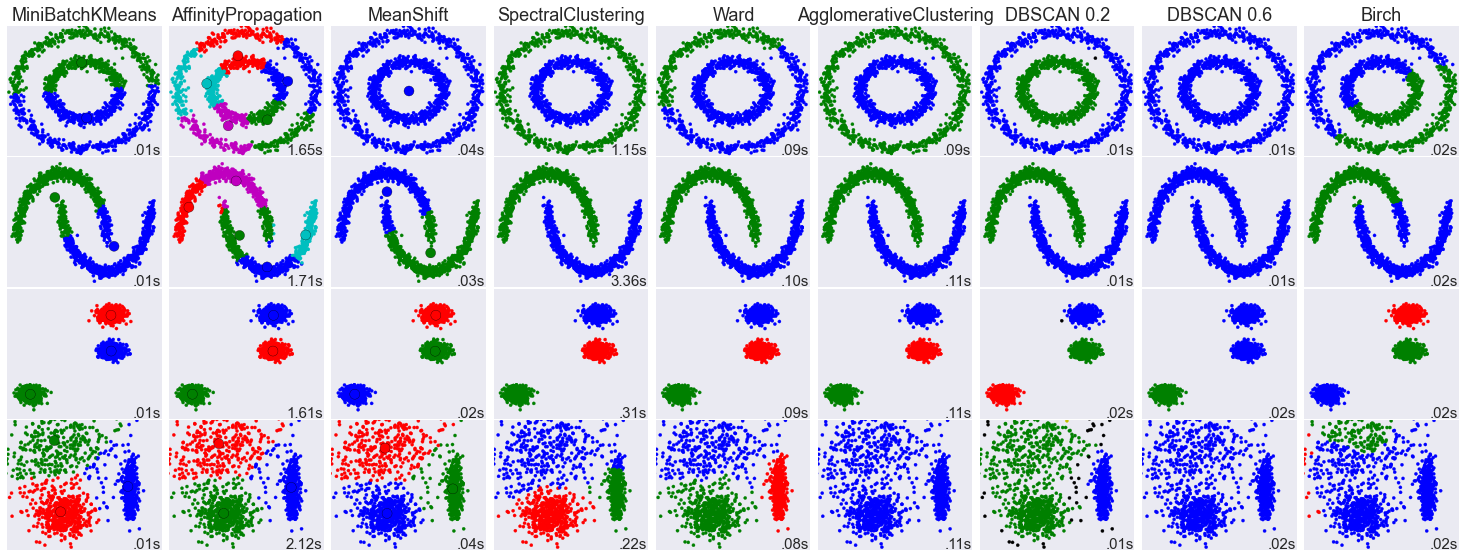

In [10]:
clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN 0.2', 'DBSCAN 0.6', 'Birch']
    
plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

for i_dataset, dataset in enumerate(clusters_list):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # clustering estimators ---------------------------

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    connectivity = kneighbors_graph(X, n_neighbors=10)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    n_clusters = max(y) + 1
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    dbscan6 = cluster.DBSCAN(eps=.6)
    
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=n_clusters,
        connectivity=connectivity)
    birch = cluster.Birch(n_clusters=n_clusters)

    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, dbscan6, birch]
    # ---------------------------------------------------------
    
    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(5, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()